In [234]:
import torch
from torch import nn

import pandas as pd
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [235]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [236]:
n_samples = 1000

X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=0)

In [237]:
X.shape, y.shape

((1000, 2), (1000,))

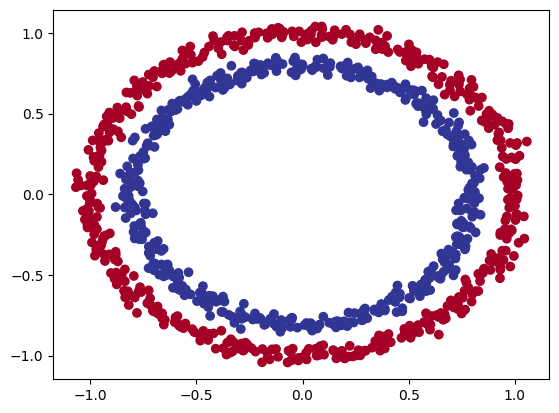

In [238]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [239]:
X = torch.from_numpy(X).float().to(device)
y = torch.from_numpy(y).float().to(device)

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [241]:
class CircleModel(nn.Module):

  def __init__(self, input_size, output_size=1):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=8),
        nn.ReLU(),
        nn.Linear(in_features=8, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=1)
    )

  def forward(self, x):
    return self.seq(x)

In [242]:
model = CircleModel(input_size=2).to(device)
model

CircleModel(
  (seq): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [243]:
preds = model(X_test)

In [244]:
preds = torch.round(preds.squeeze())

In [245]:
def accuracy_fn(y_true, y_preds):
  n_correct = torch.eq(y_true, y_preds).sum().item()
  return (n_correct / len(y_preds)) * 100

In [246]:
accuracy_fn(y_test, preds)

46.0

In [247]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3)

In [248]:
torch.manual_seed(42)

epochs = 1000

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  accuracy = accuracy_fn(y_true=y_train, y_preds=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  train_losses.append(loss.item())
  train_accuracies.append(accuracy)

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_true=y_test, y_preds=test_preds)

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

  if epoch % 10 == 0:
    print(f'[INFO] Epoch: {epoch + 1} | Train Loss: {loss.item():.4f} | Train Accuracy: {accuracy:.4f} | Test Loss: {test_loss.item():.4f} | Test Accuracy: {test_accuracy:.4f}')

[INFO] Epoch: 1 | Train Loss: 0.6910 | Train Accuracy: 55.3750 | Test Loss: 0.6915 | Test Accuracy: 49.5000
[INFO] Epoch: 11 | Train Loss: 0.6897 | Train Accuracy: 51.0000 | Test Loss: 0.6920 | Test Accuracy: 46.0000
[INFO] Epoch: 21 | Train Loss: 0.6885 | Train Accuracy: 50.1250 | Test Loss: 0.6912 | Test Accuracy: 46.0000
[INFO] Epoch: 31 | Train Loss: 0.6874 | Train Accuracy: 52.2500 | Test Loss: 0.6899 | Test Accuracy: 49.0000
[INFO] Epoch: 41 | Train Loss: 0.6861 | Train Accuracy: 52.8750 | Test Loss: 0.6887 | Test Accuracy: 50.0000
[INFO] Epoch: 51 | Train Loss: 0.6846 | Train Accuracy: 53.2500 | Test Loss: 0.6872 | Test Accuracy: 49.5000
[INFO] Epoch: 61 | Train Loss: 0.6830 | Train Accuracy: 54.2500 | Test Loss: 0.6853 | Test Accuracy: 50.5000
[INFO] Epoch: 71 | Train Loss: 0.6809 | Train Accuracy: 54.6250 | Test Loss: 0.6829 | Test Accuracy: 50.0000
[INFO] Epoch: 81 | Train Loss: 0.6780 | Train Accuracy: 55.0000 | Test Loss: 0.6797 | Test Accuracy: 51.0000
[INFO] Epoch: 91 | T

In [249]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_test).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

accuracy_fn(y_true=y_test, y_preds=y_preds)

100.0

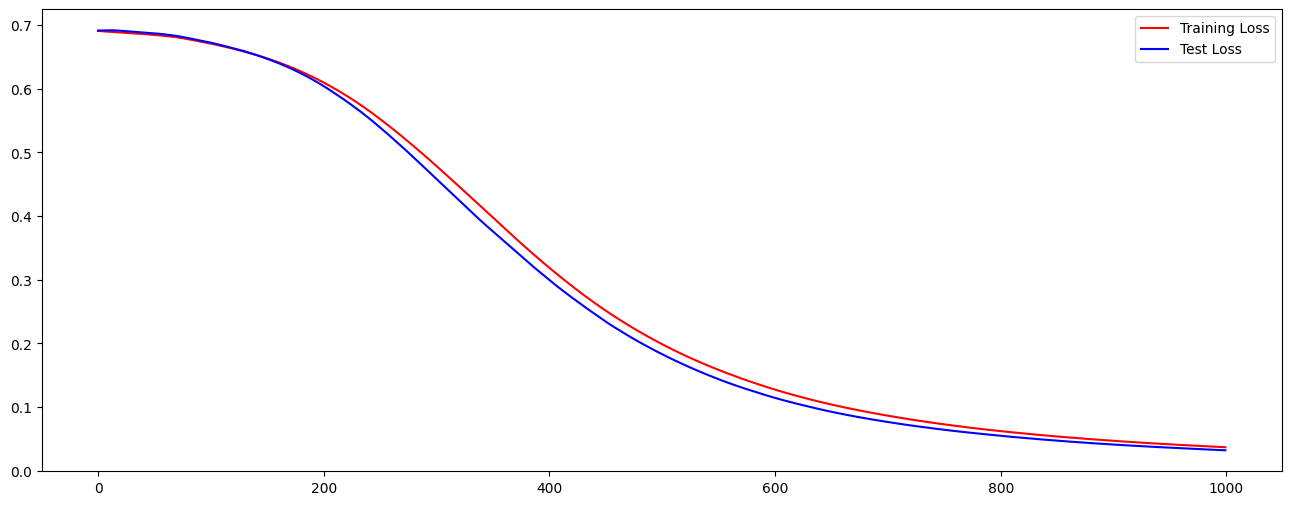

In [250]:
plt.figure(figsize=(16, 6))
plt.plot(range(len(train_losses)), train_losses, c='r', label='Training Loss')
plt.plot(range(len(test_losses)), test_losses, c='b', label='Test Loss')
plt.legend();

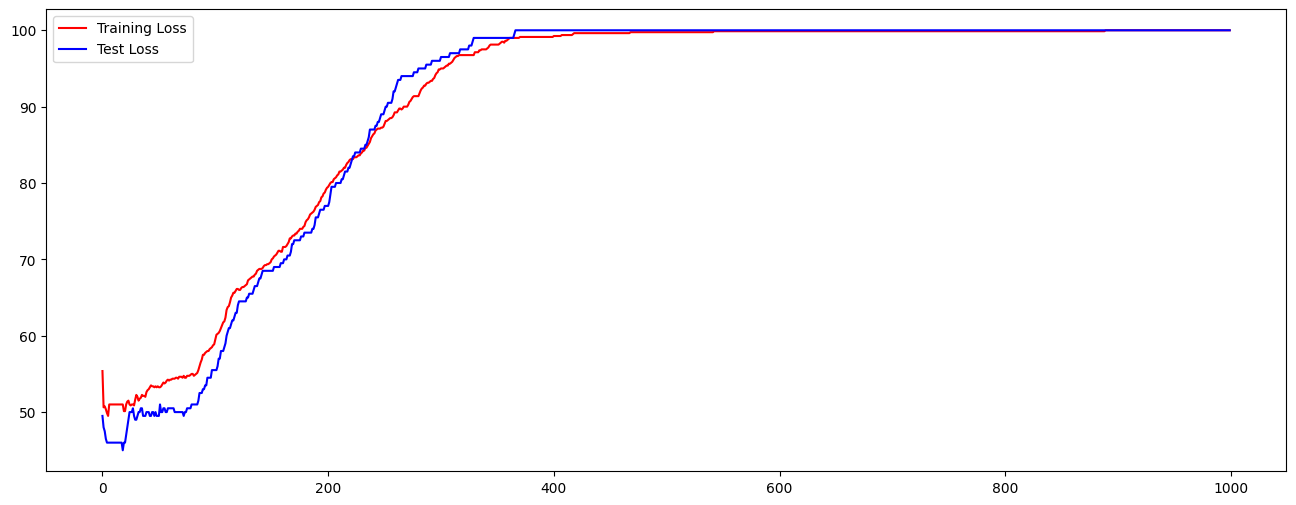

In [252]:
plt.figure(figsize=(16, 6))
plt.plot(range(len(train_accuracies)), train_accuracies, c='r', label='Training Loss')
plt.plot(range(len(test_accuracies)), test_accuracies, c='b', label='Test Loss')
plt.legend();